Overview
1. Loading Datasets - Transforming Images
2. VV-16 with modification to network head
3. Using pre-trained models
4. Storing Intermediate models
5. ResNet
6. Inception v3


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#Datasets, Transforms and Visualisations

In [ ]:
transform_train = transforms.Compose([
                                      transforms.RandomResizedCrop(224),    #Because VGG and Resnet require inputs of 224x224
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  #setting mean and std deviation across all 3 channels (RGB)
])

transform_test = transforms.Compose([
                                      transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
num_classes = 10
batch_size = 4

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
8


In [ ]:
def imshow(img, title):
  npimg = img.numpy() / 2 + 0.5   #unnormalizing the image -> img * stddev + mean
  plt.figure(figsize = (batch_size,1))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.title(title)
  plt.show()

In [ ]:
def show_batch_images(dataloader):
  images, labels = next(iter(dataloader))
  img = torchvision.utils.make_grid(images)
  imshow(img, title=[str(x.item()) for x in labels])

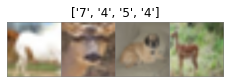

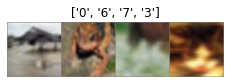

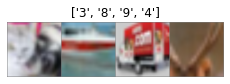

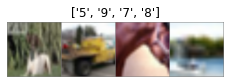

In [ ]:
for i in range(4):
  show_batch_images(trainloader)

#Creating VGG16

In [ ]:
from torchvision import models

In [ ]:
vgg = models.vgg16_bn()   #bn -> batch normalization

In [ ]:
print(vgg)

In [ ]:
print(vgg.features[0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [ ]:
print(vgg.classifier[-1])
print(vgg.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)
Linear(in_features=4096, out_features=1000, bias=True)


In [ ]:
final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1]   #all vgg classifiers except last
mod_classifier.extend([nn.Linear(final_in_features, num_classes)])
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [ ]:
vgg.classifier = nn.Sequential(*mod_classifier)
print(vgg)

#Train CIFAR10

In [ ]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
def evaluation(dataloader, model):
  total, correct = 0, 0
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred==labels).sum().item()
  return 100*correct/total

In [ ]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

In [ ]:
import time

In [ ]:
%%time
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

  for i, data in enumerate(trainloader, 0):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()

    outputs = vgg(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()

    del inputs, labels, outputs
    torch.cuda.empty_cache()

    if i%100==0:
      print('Iteration: %d/%d, Loss = %.2f' %(i, n_iters, loss.item()))

  loss_epoch_arr.append(loss.item())

  print('Epoch: %d/%d ; Test acc: %0.2f ; Train acc: %0.2f' %(epoch+1, max_epochs, 
                                                              evaluation(testloader, vgg), evaluation(trainloader, vgg)))

plt.plot(loss_epoch_arr)
plt.show() 

#Freeze Layers of Convolutional Operations

In [ ]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
vgg =models.vgg16_bn(pretrained=True)   #Downloading pretrained models of vgg -> contains optimum weights and biases when trained for imagenet

In [ ]:
final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1]   #all vgg classifiers except last
mod_classifier.extend([nn.Linear(final_in_features, num_classes)])
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [ ]:
vgg.classifier = nn.Sequential(*mod_classifier)
print(vgg)

In [ ]:
#prevent update of parameters during backpropogation
for param in vgg.parameters():
  param.requires_grad = False

In [ ]:
#Removing and adding last layer again. We do this so that the params of last layer can be updated and are not frozen
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)

In [ ]:
for param in vgg.parameters():
  if param.requires_grad:
    print(param.shape)    #only weights and biases in last layer are updatable

torch.Size([10, 4096])
torch.Size([10])


In [ ]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

In [ ]:
%%time
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

  for i, data in enumerate(trainloader, 0):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()

    outputs = vgg(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()

    del inputs, labels, outputs
    torch.cuda.empty_cache()

    if i%100==0:
      print('Iteration: %d/%d, Loss = %.2f' %(i, n_iters, loss.item()))

  loss_epoch_arr.append(loss.item())

  print('Epoch: %d/%d ; Test acc: %0.2f ; Train acc: %0.2f' %(epoch+1, max_epochs, 
                                                              evaluation(testloader, vgg), evaluation(trainloader, vgg)))

plt.plot(loss_epoch_arr)
plt.show() 

#With Model Copies

In [ ]:
import copy

In [ ]:
%%time
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

  for i, data in enumerate(trainloader, 0):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()

    outputs = vgg(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()

    del inputs, labels, outputs
    torch.cuda.empty_cache()

    if min_loss>loss.item():
      min_loss = loss.item()
      best_model = copy.deepcopy(vgg.state_dict())
      print('Min loss %0.2f' %(min_loss))
      
    if i%100==0:
      print('Iteration: %d/%d, Loss = %.2f' %(i, n_iters, loss.item()))

  loss_epoch_arr.append(loss.item())

  print('Epoch: %d/%d ; Test acc: %0.2f ; Train acc: %0.2f' %(epoch+1, max_epochs, 
                                                              evaluation(testloader, vgg), evaluation(trainloader, vgg)))

plt.plot(loss_epoch_arr)
plt.show() 

In [ ]:
vgg.load_state_dict(best_model)
print(evaluation(trainloader,vgg))
print(evaluation(testloader,vgg))

#ResNet Model

In [ ]:
resnet = models.resnet18(pretrained=True)
print(resnet)

In [ ]:
#prevent update of parameters during backpropogation
for param in resnet.parameters():
  param.requires_grad = False

In [ ]:
#Removing and adding last layer again. We do this so that the params of last layer can be updated and are not frozen
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

In [ ]:
for param in resnet.parameters():
  if param.requires_grad:
    print(param.shape)    #only weights and biases in last layer are updatable

torch.Size([10, 512])
torch.Size([10])


In [ ]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(resnet.parameters(), lr=0.01)

Min loss 1.73
Iteration: 0/3125, Loss = 1.73
Min loss 0.86
Min loss 0.74
Min loss 0.66
Iteration: 100/3125, Loss = 1.16
Min loss 0.64
Iteration: 200/3125, Loss = 1.08
Iteration: 300/3125, Loss = 1.09
Min loss 0.59
Iteration: 400/3125, Loss = 1.15
Iteration: 500/3125, Loss = 1.82
Iteration: 600/3125, Loss = 0.91
Min loss 0.52
Iteration: 700/3125, Loss = 1.30
Iteration: 800/3125, Loss = 1.59
Min loss 0.46
Iteration: 900/3125, Loss = 0.70
Iteration: 1000/3125, Loss = 1.12
Iteration: 1100/3125, Loss = 1.73
Iteration: 1200/3125, Loss = 1.52
Iteration: 1300/3125, Loss = 0.86
Iteration: 1400/3125, Loss = 1.22
Iteration: 1500/3125, Loss = 1.07
Iteration: 1600/3125, Loss = 1.29
Iteration: 1700/3125, Loss = 1.65
Iteration: 1800/3125, Loss = 1.08
Iteration: 1900/3125, Loss = 1.46
Iteration: 2000/3125, Loss = 1.20
Iteration: 2100/3125, Loss = 1.08
Iteration: 2200/3125, Loss = 0.93
Iteration: 2300/3125, Loss = 1.54
Iteration: 2400/3125, Loss = 1.09
Iteration: 2500/3125, Loss = 1.46
Min loss 0.30
It

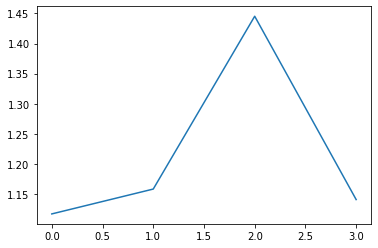

CPU times: user 13min 48s, sys: 2min 8s, total: 15min 57s
Wall time: 15min 55s


In [ ]:
%%time
loss_epoch_arr = []
max_epochs = 4

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

  for i, data in enumerate(trainloader, 0):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()

    outputs = resnet(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()

    del inputs, labels, outputs
    torch.cuda.empty_cache()

    if min_loss>loss.item():
      min_loss = loss.item()
      best_model = copy.deepcopy(resnet.state_dict())
      print('Min loss %0.2f' %(min_loss))
      
    if i%100==0:
      print('Iteration: %d/%d, Loss = %.2f' %(i, n_iters, loss.item()))

  loss_epoch_arr.append(loss.item())

  print('Epoch: %d/%d' %(epoch+1, max_epochs))

plt.plot(loss_epoch_arr)
plt.show() 

In [ ]:
resnet.load_state_dict(best_model)
print('Train acc: %0.2f' %(evaluation(trainloader,resnet)))
print('Test acc: %0.2f' %(evaluation(testloader,resnet)))

Train acc: 56.65
Test acc: 56.35


#Inception Model

In [ ]:
import copy

In [ ]:
inception = models.inception_v3(pretrained=True)
print(inception)

In [ ]:
#prevent update of parameters during backpropogation
for param in inception.parameters():
  param.requires_grad = False

In [ ]:
aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

In [ ]:
for param in inception.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 768])
torch.Size([10])


In [ ]:
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, num_classes)

In [ ]:
for param in inception.parameters():
  if param.requires_grad:
    print(param.shape)

In [ ]:
transform_train = transforms.Compose([
                                      transforms.RandomResizedCrop(299),    #Because VGG and Resnet require inputs of 299x299
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  #setting mean and std deviation across all 3 channels (RGB)
])

transform_test = transforms.Compose([
                                      transforms.RandomResizedCrop(299),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
inception = inception.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(), lr=0.01)

In [ ]:
def evaluation_inception(dataloader, model):
  total, correct = 0, 0
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs, aux_outputs = model(inputs)
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred==labels).sum().item()
  return 100*correct/total

Min loss 3.09
Iteration: 0/3125, Loss = 3.09
Min loss 2.99
Min loss 2.90
Min loss 2.89
Min loss 2.86
Min loss 2.81
Min loss 2.78
Min loss 2.71
Min loss 2.70
Min loss 2.68
Min loss 2.64
Min loss 2.61
Min loss 2.56
Iteration: 100/3125, Loss = 2.60
Min loss 2.51
Min loss 2.41
Min loss 2.37
Min loss 2.33
Min loss 2.28
Min loss 2.22
Iteration: 200/3125, Loss = 2.62
Min loss 2.19
Min loss 2.17
Min loss 2.05
Iteration: 300/3125, Loss = 2.43
Min loss 2.01
Min loss 2.00
Min loss 1.95
Min loss 1.93
Iteration: 400/3125, Loss = 2.25
Min loss 1.91
Min loss 1.90
Min loss 1.81
Iteration: 500/3125, Loss = 2.33
Min loss 1.80
Min loss 1.76
Min loss 1.75
Min loss 1.68
Min loss 1.64
Iteration: 600/3125, Loss = 1.86
Min loss 1.54
Iteration: 700/3125, Loss = 2.18
Iteration: 800/3125, Loss = 1.77
Min loss 1.50
Iteration: 900/3125, Loss = 2.63
Min loss 1.40
Min loss 1.31
Iteration: 1000/3125, Loss = 1.59
Iteration: 1100/3125, Loss = 1.91
Iteration: 1200/3125, Loss = 2.08
Iteration: 1300/3125, Loss = 1.96
Iter

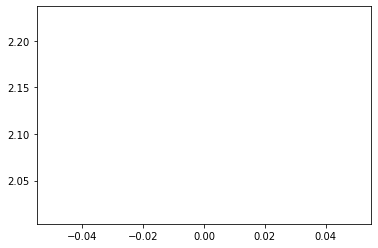

CPU times: user 12min 25s, sys: 2min 33s, total: 14min 58s
Wall time: 14min 57s


In [ ]:
%%time
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

  for i, data in enumerate(trainloader, 0):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()

    outputs, aux_outputs = inception(inputs)
    loss = loss_fn(outputs, labels) + 0.3 * loss_fn(aux_outputs, labels)
    loss.backward()
    opt.step()

    if min_loss>loss.item():
      min_loss = loss.item()
      best_model = copy.deepcopy(inception.state_dict())
      print('Min loss %0.2f' %(min_loss))
      
    if i%100==0:
      print('Iteration: %d/%d, Loss = %.2f' %(i, n_iters, loss.item()))

    del inputs, labels, outputs
    torch.cuda.empty_cache()

  loss_epoch_arr.append(loss.item())

  print('Epoch: %d/%d' %(epoch+1, max_epochs))

plt.plot(loss_epoch_arr)
plt.show() 

In [ ]:
inception.load_state_dict(best_model)
#print('Train acc: %0.2f' %(evaluation_inception(trainloader,inception)))
print('Test acc: %0.2f' %(evaluation_inception(testloader,inception)))